## Importando pacotes

In [25]:
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sp
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, KFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn import metrics
from impyute.imputation.cs import fast_knn, mice

In [2]:
sys.setrecursionlimit(100000)

## Carregando os dados

In [3]:
train = pd.read_csv('../Datasets/train_titanic.csv')

In [4]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Pré-processamento

### Remoção de atributos

Alguns atributos serão removidos devido sua alta cardinalidade, o que pode apresentar dificuldade ao modelo em identificar tanto padrões, impossibilitando a generalização do modelo

In [5]:
[f'Attribute {i} has {len(train[i].unique())} unique values.' for i in train.columns]

['Attribute PassengerId has 891 unique values.',
 'Attribute Survived has 2 unique values.',
 'Attribute Pclass has 3 unique values.',
 'Attribute Name has 891 unique values.',
 'Attribute Sex has 2 unique values.',
 'Attribute Age has 89 unique values.',
 'Attribute SibSp has 7 unique values.',
 'Attribute Parch has 7 unique values.',
 'Attribute Ticket has 681 unique values.',
 'Attribute Fare has 248 unique values.',
 'Attribute Cabin has 148 unique values.',
 'Attribute Embarked has 4 unique values.']

Como podemos observar os atributos com maiores cardinalidade são:
+ PassengerId
+ Name
+ Ticket
+ Cabin

Por isso, esses atributos serão removidos

In [6]:
train_r = train.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)

## Verificando a correlação dos atributos

In [7]:
corr_train = train_r.corr()

<AxesSubplot:>

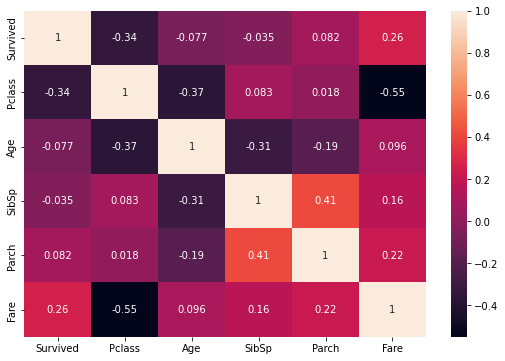

In [8]:
plt.figure(figsize=(9,6))
sns.heatmap(corr_train, annot=True)

É possível observar que não há atributos altos correlacionados. A maior correlação encontrada foi entre **Parch** e **Fare** com 22%.

### Tratamento de valores ausentes

In [9]:
#verificando a quantidade de valores ausentes
train_r.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [10]:
#verificando o percentual de valores ausentes
train_r.isna().sum()/len(train_r)

Survived    0.000000
Pclass      0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Embarked    0.002245
dtype: float64

Observamos que o atributo **Age** contém 177 e 86 de valores ausentes no conjunto de treino e teste, respectivamente. O atributo **Embarked** tem 2 valores ausentes no conjunto de treino e 1 valor ausente para o atributo **Fare** no conjunto de teste.

Para tratamento, utilizarei a técnica de imputação **Multiple imputation by chained equations (MICE)** para o atributo **Age**. Para os atributos **Embarked** e **Fare** será utilizado a remoção dos valores ausentes, uma vez que a presença é bem pequena.

A técnica MICE, em vez de utilizar apenas uma imputação, preenche os valores ausentes utilizando várias imputações de forma iterativa até uma conversão. 

Mais informações sobre essa técnica pode ser encontrada neste [artigo](https://www.jstatsoft.org/article/view/v045i03/v45i03.pdf).

Abaixo segue uma animação do funcionamento da técnica para três variáveis. Referência: [medium](https://medium.com/@ofirdi/mice-is-nice-but-why-should-you-care-e66698f245a3)

<img src="mice.gif" width=600 height=600 />

In [11]:
#removendo valores ausentes nos atributos Embarked e Fare
train_r.dropna(subset=['Embarked'], inplace=True)

In [12]:
train_r.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

O MICE não aceita atributos categóricos. Por isso, realizarei o one hot encoding nos atributos **Sex** e **Embarked** primeiro para posteriormente aplicar o MICE

### Conversão de atributos categóricos

Conversão utilizando a One Hot Enconding para os atributos **Sex** e **Embarked**

In [13]:
#aplicando o one hot enconding
train_r = pd.get_dummies(train_r, columns=['Sex','Embarked'])

### Aplicação da técnica MICE

In [14]:
#aplicando o MICE para o atributo Age
imputed_values_train = mice(train_r.values)

In [15]:
#convertendo o resultado em dataframe
train_r = pd.DataFrame(imputed_values_train, columns=train_r.columns)

In [16]:
#verificando se há valores ausentes
train_r.isnull().sum()

Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

### Remoção de duplicatas

In [17]:
#removendo duplicatas
train_r.drop_duplicates(inplace=True)

In [18]:
train_r

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.00000,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.00000,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.00000,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.00000,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.00000,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
883,0.0,3.0,39.00000,0.0,5.0,29.1250,1.0,0.0,0.0,1.0,0.0
885,1.0,1.0,19.00000,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0
886,0.0,3.0,23.39686,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,1.0
887,1.0,1.0,26.00000,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0


## Resetando o index do dataframe

In [19]:
train_r.reset_index(drop=True,inplace=True)

In [20]:
train_r

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3.0,22.00000,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,38.00000,1.0,0.0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1.0,3.0,26.00000,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.00000,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0.0,3.0,35.00000,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
773,0.0,3.0,39.00000,0.0,5.0,29.1250,1.0,0.0,0.0,1.0,0.0
774,1.0,1.0,19.00000,0.0,0.0,30.0000,1.0,0.0,0.0,0.0,1.0
775,0.0,3.0,23.39686,1.0,2.0,23.4500,1.0,0.0,0.0,0.0,1.0
776,1.0,1.0,26.00000,0.0,0.0,30.0000,0.0,1.0,1.0,0.0,0.0


## Construindo o modelo

In [21]:
#dividindo o conjunto de treino em conjunto de atributos e classe (alvo)
train_X = train_r.drop(['Survived'],axis=1)
train_y = train_r['Survived']

In [22]:
#construção do gridSearch
def gridSearchCV(X,y,kind_grid):   
    
    #hiperparametro C
    C = np.random.rand(1,50)[0] 
    #hiperparametro gamma
    gamma = ['auto','scale',0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

    #especificando os hiper-parametros de busca 
    #o parametro C é configurado com uma lista randômica uniforme de 50 valores
    parameters = {'SVM__C':C, 'SVM__kernel':['rbf'], 'SVM__gamma':gamma}
    
    #pipeline para realizar normalização dos atributos
    norm_transformer = Pipeline(steps=[('minMaxScaler', MinMaxScaler())])

    #seleção dos atributos que serão normalizados
    norm_feat = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

    #compondo o pipeline de aplicação da normalização
    preprocessor = ColumnTransformer(transformers=[
        ('norm_feat', norm_transformer, norm_feat)
    ])

    #criando o modelo atraves de pipeline com o preprocessamento e aplicação do classificador
    model = Pipeline(steps=[('processor', preprocessor),   
                            ('SVM', SVC())])
    
    #instanciamento do GridSearch com o modelo criado e o conjunto de parametros
    #parametro *scoring* calcula todas as metricas definidas no dicionario
    #parametro *refit* faz o gridsearch escolher o melhor parametro de acordo com essa metrica, ou seja, ele não consegue 
    #decidir dentre todas as metricas calculadas. É preciso escolher apenas uma metrica
    #paramentro *cv* usa a estrategia de split usando fold. Quando setamos um numero inteiro, o grid utiliza o StratifiedKFold, o qual
    # faz o split de modo que os folds preservem o percentual de distribuição das classes alvos
    if kind_grid == 'gridSearch':        
        grid = GridSearchCV(model, 
                            param_grid=parameters, 
                            cv=5, 
                            n_jobs=-1, 
                            scoring='accuracy')
    else:        
        grid = RandomizedSearchCV(model, 
                                  param_distributions=parameters, 
                                  n_iter=10, 
                                  cv=5, 
                                  n_jobs=-1,
                                  scoring='accuracy')

    #treinametro do modelo com o conjunto de teste
    grid.fit(X,y)
    
    #imprime o melhor score 
    print(f'Best_score for training set: {grid.best_score_}')
    
    #imprime o melhor conjunto de parametro
    print(f'Best_param for training set: {grid.best_params_}')
     
    return grid

In [23]:
#criando o 10-kfold 
kfold = KFold(n_splits=10, shuffle=True)

#armazena as accuracias,matrizes de confusão,recall,precision, f1 de cada iteração
list_acc=[]
list_recall=[]
list_precision=[]
list_f1_score=[]

#realizando a análise em cada fold iterativamente
for train_split, test_split in kfold.split(train_r): #percorre cada fold (1,2,3,...,10)
    
    #cria o conjunto de treino e teste referente ao respectivo fold(i)
    X_train, X_test, y_train, y_test = train_X.loc[train_split], train_X.loc[test_split], train_y.loc[train_split], train_y.loc[test_split]
    
    #aplica o gridSearch para encontrar os melhores parametros no conjunto de treinamento
    grid = gridSearchCV(X_train, y_train,'gridSearch')
    
    #aplica o preditor com os melhores parametros encontrados no conjunto de teste
    y_pred = grid.predict(X_test)
    
    #armazena as metricas 
    list_acc.append(accuracy_score(y_test,y_pred))
    list_recall.append(recall_score(y_test,y_pred))
    list_precision.append(precision_score(y_test,y_pred))
    list_f1_score.append(f1_score(y_test,y_pred))

Best_score for training set: 0.7014285714285714
Best_param for training set: {'SVM__C': 0.9719214129345953, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best_score for training set: 0.6971428571428572
Best_param for training set: {'SVM__C': 0.9944789916821587, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best_score for training set: 0.71
Best_param for training set: {'SVM__C': 0.9362650779668331, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best_score for training set: 0.69
Best_param for training set: {'SVM__C': 0.9839785070677154, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best_score for training set: 0.6971428571428572
Best_param for training set: {'SVM__C': 0.9401708353739999, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best_score for training set: 0.7042857142857143
Best_param for training set: {'SVM__C': 0.241350726196623, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}
Best_score for training set: 0.71
Best_param for training set: {'SVM__C': 0.889291076138322, 'SVM__gamma': 'sca

In [24]:
#resultados do conjunto de teste
# media - desvio padrão
print('MÉTRICAS EM RELAÇÃO AO CONJUNTO DE TESTE')
print('\n')
print(f'Accuracy: {np.array(list_acc).mean():.2f} - ({np.array(list_acc).std():.3f})')
print(f'Recall: {np.array(list_recall).mean():.2f} - ({np.array(list_recall).std():.3f})')
print(f'Precision: {np.array(list_precision).mean():.2f} - ({np.array(list_precision).std():.3f})')
print(f'F1_score: {np.array(list_f1_score).mean():.2f} - ({np.array(list_f1_score).std():.3f})')

MÉTRICAS EM RELAÇÃO AO CONJUNTO DE TESTE


Accuracy: 0.70 - (0.056)
Recall: 0.49 - (0.117)
Precision: 0.69 - (0.093)
F1_score: 0.57 - (0.101)
